In [1]:
import os
import json
import shutil
import lzma
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import scipy
import scipy.sparse as sps
from scipy.sparse import csr_matrix
import scipy.stats as st
from random import shuffle

import networkx as nx
import louvain
import igraph as ig

# from bertopic import BERTopic

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

C:\Users\rdm42\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-33a034e607f0>:22: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
def plot_degree_summary(Mwd=None, G=None):
    
    if G is None:
        dw = Mwd.sum(axis=1)
        print(f"Number of words: {Mwd.shape[0]}")
        print(f"Number of documents: {Mwd.shape[1]}")
    else:
        dw = pd.Series(dict(G.degree()))
        print(f"Number of words: {len(G)}")
        

    # Summary analysis of the network:
    gamma = 1 + dw.size/np.log(dw / dw.min()).sum()
    print(f"Network's gamma is {gamma:.2f}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("Word degree summary", size=20)

    # Words' degrees

    n = 6
    s = dw.sort_values(ascending=False)
    custom_ticks = [min((s.size//n)*l,s.size-1) for l in range(n+1)]
    custom_labels = s.index[custom_ticks]

    axs[0].set_title("Degrees", size=16)
    axs[0].set_ylabel("Word count across documents", size=12)
    axs[0].semilogy(s)
    axs[0].set_xticks(custom_ticks)
    axs[0].set_xticklabels(custom_labels, rotation=30)


    # Words degree distribution

    k = np.unique(dw)
    pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
    pk = pk/pk.sum()
    # Pk = 1-np.cumsum(pk)
    p_ideal = ((gamma-1)/k.min()) * ((k/k.min())**(-gamma))

    label = r'$\gamma$' + f" = {gamma:.2f}\n" + r'$k_{min}$' + f" = {k.min()}"
    axs[1].loglog(k, pk, 'o')
    axs[1].loglog(k, p_ideal,label=label)
    axs[1].set_title("Distribution", size=16)
    axs[1].set_xlabel("k", size=12)
    axs[1].set_ylabel("$p_k$", size=12)
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    
    return gamma, fig, axs


def plot_corr_grid(df):
    # Create pairplot with scatter plots and KDE plots for diagonal entries
    grid = sns.PairGrid(df, diag_sharey=False)

    # Map scatter plots to lower triangle
    grid.map_lower(sns.scatterplot, alpha=0.35, s=40)

    # Map KDE plots for diagonal entries
    grid.map_diag(sns.kdeplot, lw=1.5)
    grid.map_diag(sns.rugplot)

    # Calculate and display correlation coefficients
    correlation_coefficients = df.corr().values
    for i in range(len(df.columns)):
        for j in range(0, len(df.columns)):
            if i != j:
                correlation = correlation_coefficients[i, j]
                grid.axes[i, j].text(0.5, 0.95,
                                     f'Correlation: {correlation:.2f}', fontsize=10, ha='center', va='center',
                                     transform=grid.axes[i, j].transAxes, color='black')

    # Remove upper triangle by hiding the axes
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i < j:
                grid.axes[i, j].set_visible(False)

    plt.show()

In [3]:
def clean_Mwd_matrix(Mwd,words,documents,img_names=None):

    # remove elements that are too central, e.g., #covid19
    not_wanted = np.array(Mwd.sum(axis=1)).flatten()>Mwd.shape[1]/4
    text = "removing: " + " ".join(words[not_wanted])
    words = words[~not_wanted]
    Mwd = Mwd[~not_wanted,:]

    # remove documents and words with fewer than 2 links
    while True:

        # keep memory
        dim_old = Mwd.size
        
        # remove documents with less than 2 words
        wanted = np.array(Mwd.sum(axis=0)).flatten()>1
        Mwd = Mwd[:,wanted]
        documents = documents[wanted]
        if img_names is not None: img_names = img_names[wanted]

        # remove words in less than 2 documents
        not_wanted = np.array(Mwd.sum(axis=1)).flatten()<=1
        text = text + " " + " ".join(words[not_wanted])
        words = words[~not_wanted]
        Mwd = Mwd[~not_wanted,:]
        
        # exit criterion
        if (dim_old == Mwd.size): break

    # exit
    print(text)
    
    if img_names is None:
        return Mwd, words, documents
    else:
        return Mwd, words, documents, img_names


def logg(x):
    with warnings.catch_warnings(record=True) as w:
        y = np.log(x)
    y[x==0] = 0
    return y



def probability_matrices(Mwd, equalik = True, tform = False):

    if equalik: # documents equally likely
        Pwd = Mwd/Mwd.sum(axis=0).flatten()/Mwd.shape[1]
        
    else: # documents proportional to their length
        Pwd = Mwd/Mwd.sum()
        
    # TF-IDF format
    if (tform):
        iw = -logg(np.sum(Mwd>0,axis=1).flatten()/Mwd.shape[1])
        Pwd = sps.diags(np.array(iw)[0])*Pwd # TF-IDF form
        Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
        
    # words and document matrices
    pd = Pwd.sum(axis=0).flatten()
    Pww = (Pwd/pd)*(Pwd.T)
    pw = Pwd.sum(axis=1).flatten()
    Pdd = (Pwd.T/pw)*Pwd
    
    # joint words and document matrix - documents first
    Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
    Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
    Paa = Paa/2.0

    return Pwd, Pww, Pdd, Paa

In [4]:
def my_soft_louvain(A, C_start=None, seed=42):
    """
    Find the best partition of a graph using the Louvain Community Detection
    Algorithm.

    References
    [1] Blondel, V.D. et al. Fast unfolding of communities in large networks.
        J. Stat. Mech 10008, 1-12(2008).
        https://doi.org/10.1088/1742-5468/2008/10/P10008
    [2] Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden:
        guaranteeing well-connected communities. Sci Rep 9, 5233 (2019).
        https://doi.org/10.1038/s41598-019-41695-z
    [3] Nicolas Dugué, Anthony Perez. Directed Louvain : maximizing modularity
        in directed networks. [Research Report] Université d’Orléans. 2015.
        hal-01231784. https://hal.archives-ouvertes.fr/hal-01231784
    """

    np.random.seed(seed)
    
    # normalize matrix - otherwise it doesn't work -  read by rows
    A = sps.csr_matrix(A)/A.sum()
    
    # initialize the community assignment matrix to "each node is a community"
    C = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))
    
    # starting assignment
    if C_start is None:
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    
    # main loop for the different layers of Louvain
    while True:
        # improve modularity in this layer
        Clayer, improvement = _my_one_level(A,C_start)
        
        if not improvement: break
        
        # Update variables according to the new clusters
        C = C*Clayer
        A = Clayer.T*(A*Clayer)
        
        # initialize the community assignment matrix to "each node is a community"
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    # return community assignments and resulting adjacency matrix
    Q = modularity_function(A)
    return C, A, Q


def _my_one_level(A,C):

    N = A.shape[0] # number of nodes
    rand_nodes = list(range(N)) # random nodes list
    shuffle(rand_nodes) # shuffle random nodes list

    d_in = A.sum(axis=1).T # input degrees - row vector
    d_out = A.sum(axis=0) # output degrees - row vector
    A = A + A.T # sum easily accessible by row

    # main loop - loop until you do not see any improvement
    improvement = False
    while True:

        # counter for the number of nodes changing community
        nb_moves = 0
        
        # test each node
        for i in rand_nodes:
            # get the community of node i
            ci_old = C[i,0:C.shape[1]].toarray()[0]
            
            # modify C for our purposes, i.e., exclude node i
            C[i,0:C.shape[1]] = 0
            
            # build vector v for evaluating modularity increase
            v = ( A[i] - d_out[0,i]*d_in - d_in[0,i]*d_out )/2
            
            # find the maximum - best community
            ci = soft_assign(v[0,i], np.array(v*C)[0])
            
            # update matrix
            C[i,0:C.shape[1]] = ci
            
            # update counter (if needed)
            nb_moves += np.linalg.norm(ci-ci_old)

#         print(nb_moves)
        # exit if no improvement
        if (nb_moves<1e-10): break
        
        # otherwise: remove empty communities
        C = C[:,np.unique(scipy.sparse.find(C)[1])]
        
        # set improvement and reshuffle nodes for next try
        improvement = True
        shuffle(rand_nodes)

    # exit
    return C, improvement


def soft_assign(a,v):
    if (a>=0):
        u = np.array(v.data)
        n = np.where(u==u.max())[0][0]
        u = np.zeros(u.shape)
        u[n] = 1
        return np.array(u)/u.sum()

    else:
        u = -np.array(v.data)/a
        g = np.sort(u)[::-1]
        z = np.cumsum(g)-np.append(np.array(range(1,len(g)))*g[1:len(g)],-np.Inf)
        n = np.where(z>=1)[0][0]
        la = ((g[0:n+1]).sum()-1)/(n+1)
        u = u-la
        u[u<0] = 0
        return np.array(u)/u.sum()

In [5]:
def nmi_function(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2 = logg(A2)
    y = (np.multiply(A,A2)).sum()/Hc
    return y


# RDM: Why? How?
def modularity_function(A):
    y = A.diagonal().sum()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

def ncut_function(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def my_pagerank(M,q=None,c=.85,it=100):
    if q is None:
        q = np.ones((M.shape[0],1))
        
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
          r = c*M@r + (1-c)*q
    return r

def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose()*M)*z[i].transpose()
        q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = infomap_function(q)
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/infomap_function(pd))-1

    return y


# RDM: What if I'd like to use the Pww instead?
def clustering_statistics(C,Pwd,Pdd,r):

    Pwc = Pwd*C # joint word + class probability
    NMI = nmi_function(Pwc)
    Pcc = C.T*Pdd*C # joint class + class probability
    Q = modularity_function(Pcc)
    Ncut = ncut_function(Pcc)
    Infomap = infomap(C,Pdd,r)

    return [NMI, Q, Ncut, Infomap]

# Retrieving cleaned data

## LIWC data

In [6]:
path = os.path.join('data','resources','LIWC2015 Results (autocaptions_per_image).xlsx')

with pd.ExcelFile(path) as xl:
    liwc_autocaptions = xl.parse()
    
    
path = os.path.join('data','resources','LIWC2015 Results (original_captions_per_image).xlsx')

with pd.ExcelFile(path) as xl:
    liwc_captions = xl.parse()
    
    
def weighted_avg(df):

    # row-vector containing the character-lengths of the
    # caption and autocaption descriptions
    w = np.array([len(df.index.get_level_values(x)[0])
                  for x in df.index.get_level_values('origin')])[np.newaxis,:]
    
    # mean of LIWC numerical variables weighted by description length
    r = w@df.values / w.sum()

    return pd.Series(r.flatten(), index=df.columns)


q = liwc_autocaptions.merge(liwc_captions.drop(columns=['post_dir','user','URL']),
                            how='left', on='short', validate='m:1', suffixes=('__Auto_caption','__caption')) \
                     .set_index(['img_name','Auto_caption','caption']) \
                     .drop(columns=['img_path','post_dir','short','user','URL'])

q.columns = pd.MultiIndex.from_tuples([tuple(col.split('__')) for col in q.columns],
                                      names=['var','origin'])

liwc_vars = q.stack() \
             .groupby(level=['img_name','Auto_caption','caption']) \
             .apply(weighted_avg) \
             [liwc_captions.loc[0,'WC':].index]
liwc_vars.index = liwc_vars.index.droplevel([1,2])
liwc_vars *= 1e-2

In [7]:
project_cols = ['female','body','sexual']
liwc = liwc_vars[project_cols]

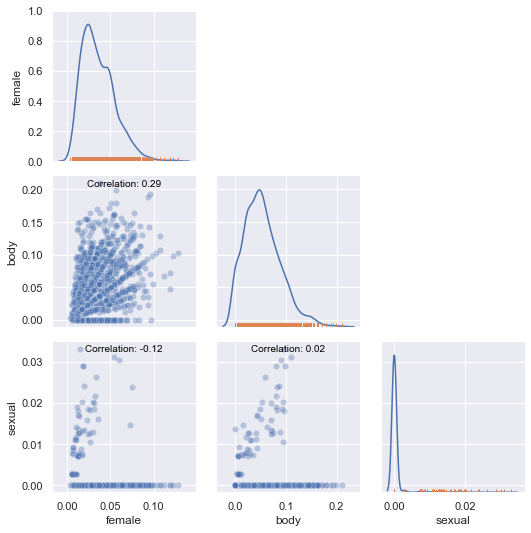

In [8]:
plot_corr_grid(liwc)

# Remark: each dot represents a document/image

# Buen insight para presentación!

## Extra document attributes

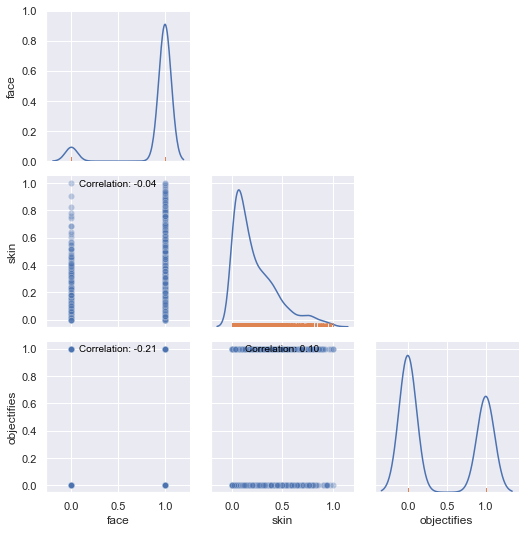

In [9]:
path = os.path.join('..','0_data','gold','8_data_model.xlsx')
with pd.ExcelFile(path) as xl:
    extra_attr = xl.parse() \
                   .eval("img_name = img_path.apply(@os.path.basename)") \
                   .set_index('img_name') \
                   .drop(columns=['img_path','text_deep_clean'])
    
plot_corr_grid(extra_attr)

# Remark: each dot represents a document/image

## Reading documents and merging data

In [10]:
%%time

text_col = 'text_deep_clean'
path = os.path.join('..','0_data','silver','7_text_clean_large.xlsx')
with pd.ExcelFile(path) as xl:
    data = xl.parse(index_col=0) \
             .set_index('img_name')[[text_col]] \
             .drop_duplicates(subset=text_col)
    

join_kwargs = dict(
    on='img_name',
    how='inner',
    validate='1:1'
)
    
data = data.join(liwc, **join_kwargs) \
           .join(extra_attr, **join_kwargs) \
           .query("objectifies==0")

Wall time: 2.5 s


# Occurrence matrix $M_{wd}$

In [11]:
%%time

documents = data[text_col].values
img_names = data.index.values

words = np.unique([token
                   for doc in documents
                       for token in doc.split()])

words_dict = {wrd:i for i,wrd in enumerate(words)}

Wall time: 83.1 ms


In [12]:
%%time

# occurrence matrix for words
Mwd = csr_matrix((words.size, documents.size), dtype = np.int8)
print(f"Mwd shape: {Mwd.shape}")

for j,doc in tqdm(enumerate(documents)):
    for token in doc.split():
        Mwd[words_dict[token],j] += 1

        
# remove words that are used once or twice
select = np.array(Mwd.sum(axis=1) > 2).flatten()
Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = np.array(Mwd.sum(axis=0) > 0).flatten()
Mwd = Mwd[:,select]
documents = documents[select]
img_names = img_names[select]

print(f"New shape: {Mwd.shape}")

0it [00:00, ?it/s]

Mwd shape: (2379, 932)


C:\Users\rdm42\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
932it [00:36, 25.27it/s]

New shape: (1245, 932)
Wall time: 36.9 s


In [13]:
# Further cleaning and probability matrices computation
Mwd, words, documents, img_names = clean_Mwd_matrix(Mwd,words,documents,img_names)
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform = True)

words_dict = {wrd:i for i,wrd in enumerate(words)}

removing: black blue brown dress foreground front hair hand jacquemus long small stand visible wear white woman 


# General overview

## Bipartite Document-Word Network Summary

Number of words: 1229
Number of documents: 932
Network's gamma is 1.86


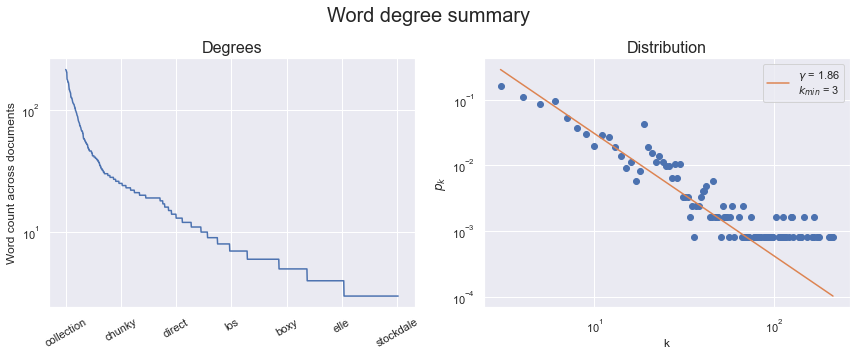

In [14]:
Mwd_df = pd.DataFrame(Mwd.A,index=words,columns=documents)
Pww_df = pd.DataFrame(Pww.A,index=words,columns=words)

gamma, fig, axs = plot_degree_summary(Mwd_df)

## Word scorings

In [15]:
Mwd_df.columns=img_names

norm = pd.DataFrame(np.linalg.inv(np.diag(Mwd_df.sum(axis=1))),
                    index=words,columns=words)

word_scorings = norm @ Mwd_df @ data.loc[img_names,'female':]

pr = my_pagerank(np.array(Pww))
word_scorings['pagerank'] = pd.Series(pr.flatten(),index=words)

display(word_scorings)

# PAGERANK NOT LOOKING GOOD - Maybe because Pww matrix is not great?
# boxplot por var
# assortativity de vars + PR + degree

,female,body,sexual,face,skin,objectifies,pagerank
abandon,0.023159,0.056248,0.000000,0.750000,0.268871,0.0,0.150064
absence,0.006496,0.006888,0.002858,1.000000,0.247275,0.0,0.150018
accessible,0.020260,0.021345,0.000000,1.000000,0.073243,0.0,0.150036
accessorize,0.035653,0.046250,0.000863,0.991304,0.180896,0.0,0.150587
accessory,0.027619,0.068852,0.003682,0.888889,0.497120,0.0,0.150103
...,...,...,...,...,...,...,...
zhou,0.015852,0.016232,0.000000,1.000000,0.180305,0.0,0.150039
zifeng,0.016450,0.012790,0.000000,1.000000,0.177738,0.0,0.150033
zip,0.032172,0.070723,0.000000,1.000000,0.240495,0.0,0.150047
zipper,0.041307,0.080590,0.000000,1.000000,0.125085,0.0,0.150101


In [16]:
word_scorings.describe()

,female,body,sexual,face,skin,objectifies,pagerank
count,1229.000000,1229.000000,1229.000000,1229.000000,1229.000000,1229.0,1229.000000
mean,0.025817,0.045207,0.001501,0.968001,0.240946,0.0,0.150104
std,0.012307,0.024046,0.002687,0.085992,0.127822,0.0,0.000132
min,0.006214,0.000000,0.000000,0.000000,0.006562,0.0,0.150004
25%,0.017248,0.026706,0.000000,0.980583,0.150233,0.0,0.150033
50%,0.024370,0.044210,0.000000,1.000000,0.228055,0.0,0.150057
75%,0.032810,0.062453,0.002361,1.000000,0.309966,0.0,0.150113
max,0.080520,0.144296,0.023091,1.000000,0.705903,0.0,0.150851


C:\Users\rdm42\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)


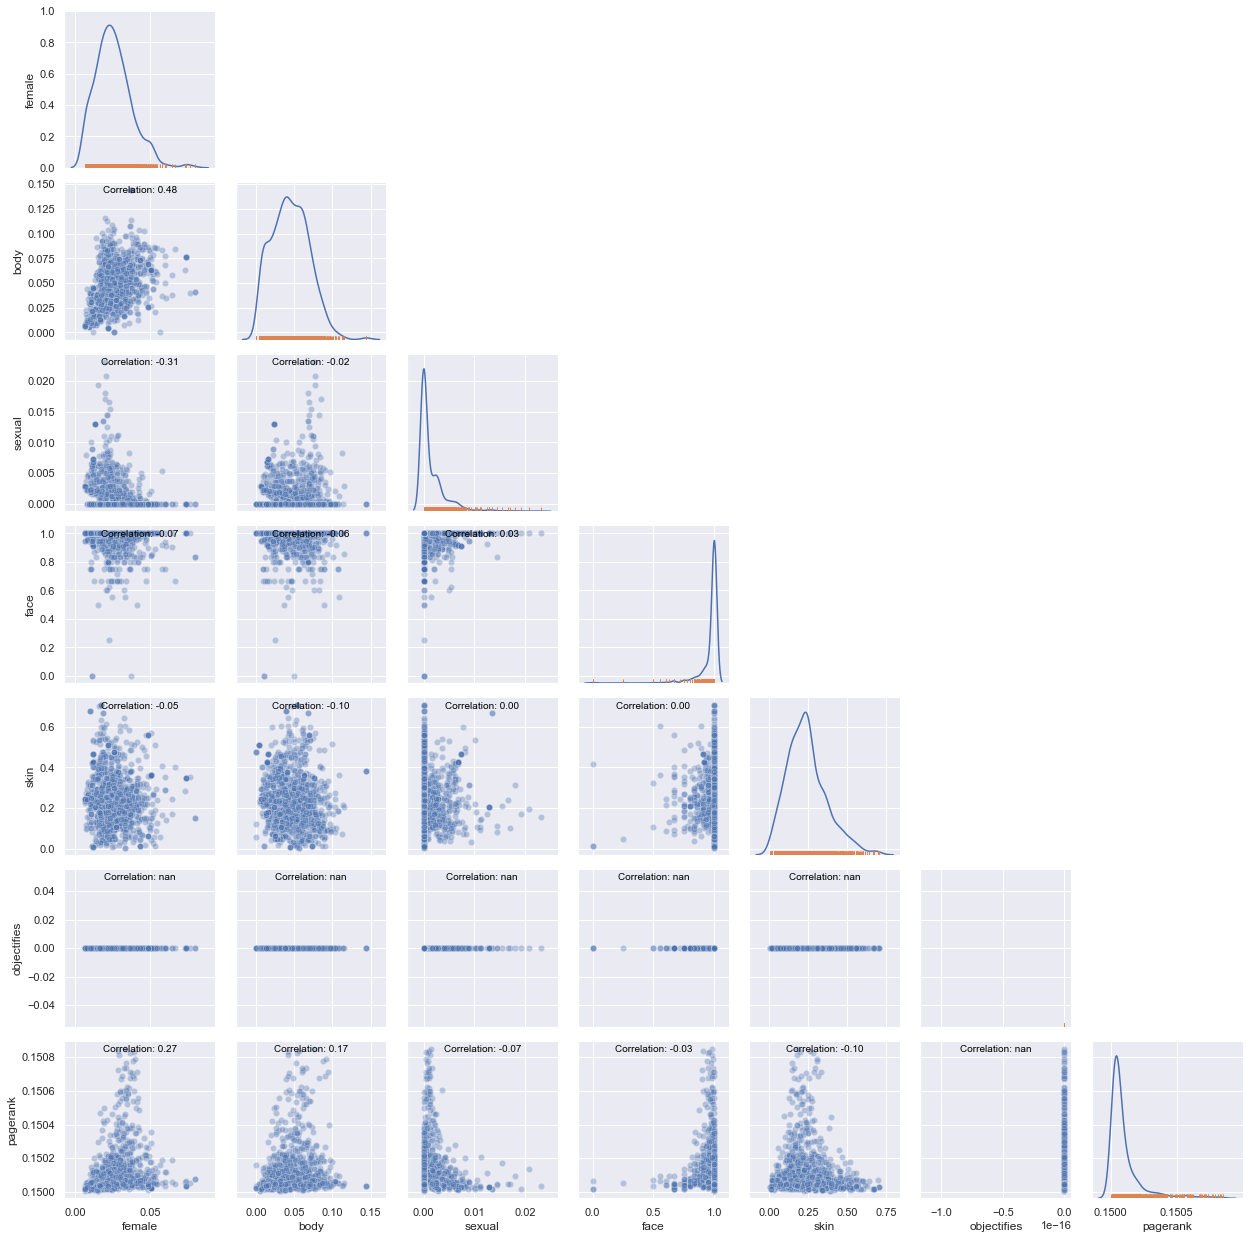

In [17]:
plot_corr_grid(word_scorings)

# Remark: each dot represents a word

## Links' weight distribution

<Axes: xlabel='Weight', ylabel='Density'>

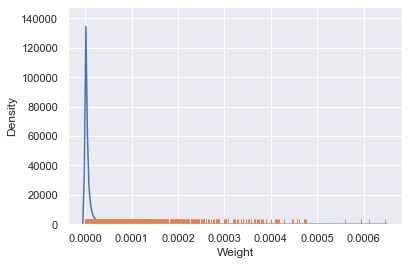

In [18]:
## Assuming that the network is undirected,
## we only process the lower triangular part
## of the adyacency matrix

links = Pww_df.where((np.triu(np.ones(Pww_df.shape))).astype(np.bool_)) \
              .melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .dropna() \
              .query("""Weight !=0""") \
              .reset_index() \
              .rename(columns={'index':'Source'})

sns.kdeplot(data=links, x='Weight')
sns.rugplot(data=links, x='Weight')

## Homophily / Assortativity analysis

In [19]:
# Wouldn't it be better to do some sort of bidimensional histogram?


# Ask professor if the implementation is correct:
## rationale?
## Is Pww correctly renormalized?

In [20]:
def plot_assortativity(df,name,x_col='node_val',y_col='neighbors_val'):
    x = df[x_col]
    y = df[y_col]
    xmin, xmax = x.min(),x.max()
    ymin, ymax = y.min(),y.max()

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # Contourf plot
    cfset = ax.contourf(xx, yy, f, cmap='Blues')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    cset = ax.contour(xx, yy, f, colors='k')
    # Label plot
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(f"Node's {name} rate")
    ax.set_ylabel(f"Neighbors' {name} rate")
    ax.set_aspect('equal', adjustable='box')
    
    plt.show()

In [21]:
# Pww = np.array(Pww)
# Pww_out_norm = Pww @ np.diag(1/Pww.sum(axis=0))
# Pww_out_norm.sum(axis=0)

In [22]:
# %%time
# G_nx = nx.from_pandas_edgelist(links, 'Source', 'Target', ['Weight'],create_using=nx.Graph())

# assortativity_dict = dict()
# use_weight_flag = True

# for var in word_scorings.columns:
#     assortativity_dict[var] = []
#     print(var)
    
#     for i in tqdm(G_nx):
#         for j in G_nx.neighbors(i):
            
#             link_weight = Pww_out_norm[words_dict[j],words_dict[i]]
            
#             # Should this be normalized according to the node's vicinity?
#             node_val = word_scorings.loc[i,var]
#             neighbor_val = word_scorings.loc[j,var]
#             w_neighbor_val = neighbor_val*link_weight
            
#             assortativity_dict[var].append((node_val, neighbor_val, w_neighbor_val))

# for var,dist in assortativity_dict.items():
#     assortativity_dict[var] = pd.DataFrame(dist, columns=['node_val','neighbors_val','w_neighbors_val'])

In [23]:
# %%time
# for name,df in assortativity_dict.items():
#     plot_assortativity(df,name,y_col='w_neighbors_val')

In [24]:
# %%time
# for name,df in assortativity_dict.items():
#     plot_assortativity(df,name,y_col='neighbors_val')

## Output for Gephi

In [25]:
# tol = links.Weight.quantile(0.05)*0
# data_gephi = links.query("Weight >= @tol").sort_values('Weight')

# Writing links
tag = "only_non_object"

links.to_csv(f'data/processed/{tag}__links.csv',
                  encoding='UTF-16',index=False)


# Writing nodes
wrds = np.unique(links.Source.tolist() + links.Target.tolist())

first_cols = ['Id','Label']
nodes = word_scorings.loc[wrds,:] \
                     .sort_index() \
                     .reset_index(names='Id') \
                     .eval("Label=Id") \
                     .rename(columns={'pagerank':'python_pagerank'})
nodes = nodes[first_cols + [col for col in nodes if col not in first_cols]]
nodes.to_csv(f'data/processed/{tag}__nodes.csv',encoding='UTF-16',index=False)

# Community assignment

In [26]:
partitions = dict()

# function to map the partition into a community assignment matrix C
# where rows represent documents, and columns represent topics
def partition_to_C(part):
    
    with warnings.catch_warnings(record=True) as w:    
        C = sps.csr_matrix((Pww.shape[0],len(part)))
        for community,nodes in enumerate(part):
            C[np.array(nodes), community] = 1
    return C

def modularity(C, A_0):
    if C.shape[0] > C.shape[1]:
        C = C.T.copy()
    
    d_0 = A_0.sum()
    A = A_0/d_0
    d = A.sum(axis=1)

    Q = (C @ ( A - d@d.T ) @ C.T).diagonal().sum()
    
    return Q


def register_partition(name,C,Pww,Pwd,partitions):
    
    partitions[name] = dict()
    partitions[name]['C'] = C
    partitions[name]['Q'] = modularity(C,Pww.copy())
    partitions[name]['Ncut'] = ncut_function(C.T @ Pww @ C)
    partitions[name]['NMI'] = nmi_function(Pwd.T @ C)
    
    with warnings.catch_warnings(record=True) as w:
        r = infomap_rank(Pww)
        partitions[name]['infomap'] = infomap(C,Pww,r)

    print(f"{name}:")
    print(f"\tModularity: {partitions[name]['Q']:.2%}")
    print(f"\tN-cut: {partitions[name]['Ncut']:.2%}")
    print(f"\tNMI: {partitions[name]['NMI']:.2%}")
    print(f"\tInfomap: {partitions[name]['infomap']:.2%}")
    print(f"\n\tShape of matrix C: {C.shape}")

In [27]:
def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y


def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r


def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = 0.85
    
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose() * M) * z[i].transpose()
        q[0,i] = (1 - (1-c)*C[:,i].sum()/M.shape[0]) * z[i].sum() - c*tmp[0,0]
    
    # extract statistics
    y = infomap_function(q)
    
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    
    # normalize
    y = (y/infomap_function(pd))-1

    return y

## Louvain

In [28]:
%%time
A = sps.csr_matrix(Pww)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight', seed=42)

C_l = partition_to_C(part)

register_partition('louvain',C_l,Pww,Pwd,partitions)

louvain:
	Modularity: 34.29%
	N-cut: 54.62%
	NMI: 51.82%
	Infomap: 5.87%

	Shape of matrix C: (1229, 14)
Wall time: 2.07 s


In [29]:
n_comm = C_l.shape[1]
word_scorings['louvain_cluster'] = C_l @ np.array(range(n_comm))[:,np.newaxis]
word_scorings.to_excel(f'data/processed/{tag}__word_scorings.xlsx')

<ipython-input-29-0b887bc21085>:3: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  word_scorings.to_excel(f'data/processed/{tag}__word_scorings.xlsx')


## Soft Louvain

In [ ]:
# refine with soft Louvain

with warnings.catch_warnings(record=True) as w:
    C_sl, _A, _Q = my_soft_louvain(Pww.copy(), partitions['louvain']['C'].copy(),seed=42)
    
register_partition('soft_louvain',C_sl,Pww,Pwd,partitions)

## Infomap

In [ ]:
infomap_clusters = G.community_infomap(edge_weights=G.es["weight"])
C_im = partition_to_C(infomap_clusters)

register_partition('infomap',C_im,Pww,Pwd,partitions)

## BerTopic

In [ ]:
# Is bertopic only used for documents?
# Does it make sense to use it in the word projection?

## BigCLAM

In [ ]:
"""
Implementation of the bigClAM algorithm.

Throughout the code, we will use tho following variables

  * F refers to the membership preference matrix. It's in [NUM_PERSONS, NUM_COMMUNITIES]
   so index (p,c) indicates the preference of person p for community c.
  * A refers to the adjency matrix, also named friend matrix or edge set. It's in [NUM_PERSONS, NUM_PERSONS]
    so index (i,j) indicates is 1 when person i and person j are friends.
"""

# import numpy as np
# import pickle
# from AGM.util.generate_data import Datagen, gen_json
import json


def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad



def train(A, C, iterations = 100, initial_F=None):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C) if initial_F is not None else initial_F

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
        print('At step %5i/%5i ll is %5.3f'%(n, iterations, ll))
    return F

In [ ]:
if __name__ == "__main__":
    # adj = np.load('data/adj.npy')
    # p2c = pickle.load(open('data/p2c.pl','rb'))
    ##generate data
    datagen = Datagen(40, [.3, .3, .2, .2],[.2, .3, .3, .2] , .1).gen_assignments().gen_adjacency()
    p2c = datagen.person2comm
    adj = datagen.adj

    F = train(adj, 4)
    F_argmax = np.argmax(F,1)
    data = gen_json(adj, p2c, F_argmax)

    # with open('../data/data.json','w') as f:
    with open('ui/assets/data.json','w') as f:
        json.dump(data,f, indent=4)

    for i,row in enumerate(F):
        print(row)
        print(p2c[i])

In [ ]:
F = train(Pww, C_l.shape[1], 1, initial_F=C_l)
F_argmax = np.argmax(F,1)

In [ ]:
row_sums = F.sum(axis=1)
F_norm = F / row_sums[:, np.newaxis]
F_norm.sum(axis=0)

In [ ]:
register_partition('BigCLAM',csr_matrix(F_norm),Pww,Pwd,partitions)

In [ ]:
F_norm.sum(axis=0)

In [ ]:
# Hacer BERTopic -- Problemas de instalación
# Hacer BigCLAM -- No funciona

# ----Calcular métricas de este y el resto de algoritmos!
# ----usar función de Erseghe


# ----Guardar asignación de cada algoritmo en diccionario,
# luego usar para calcular NMI (PREGUNTAR A ERSEGHE SI LO VE BIEN)


# Asignar cluster de vuelta a los nodos, visualizaciones en Gephi

# ----Assortativity para cualquier variable numérica asociada a nodos